In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import math 
import random
import matplotlib
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler

## Imports for different type of classfiers
from sklearn import tree # <- Decision- Trees
from sklearn import svm # <- Support Vector Machines
import sklearn.linear_model as linear_model # <- Logisitic Regression - Sigmoid Function on the Linear Regression
from sklearn.ensemble import RandomForestClassifier # <- Random Forest Classifier
from sklearn.neural_network import MLPClassifier # <- Neural Networks
from sklearn.naive_bayes import GaussianNB # <- Gaussian Naive-Bayes Classifier

## Imports for recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## Imports for splitting the data into training and test data
from sklearn.model_selection import train_test_split

## Imports for evaluating the different classifier models selected
import sklearn.metrics as metrics
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1 = pd.read_excel(r'H1B_2014.xlsx')
df2 = pd.read_excel(r'H1B_2015.xlsx')
df3 = pd.read_excel(r'H1B_2016.xlsx')
df4 = pd.read_excel(r'H1B_2017.xlsx')
df5 = pd.read_excel(r'H1B_2018.xlsx')

adding year column to the corresponding data.

In [3]:
df1['YEAR'] = 2014
df2['YEAR'] = 2015
df3['YEAR'] = 2016
df4['YEAR'] = 2017
df5['YEAR'] = 2018

In [4]:
frames=[df1, df2, df3, df4, df5]
result=pd.concat(frames, sort=False)

In [5]:
df_cleaned = result[['LCA_CASE_NUMBER',
                 'STATUS',
                 'LCA_CASE_EMPLOYER_NAME',
                 'LCA_CASE_EMPLOYER_CITY',
                 'LCA_CASE_EMPLOYER_STATE',
                 'LCA_CASE_SOC_NAME',
                 'LCA_CASE_SOC_CODE',
                 'LCA_CASE_JOB_TITLE',
                 'PW_1',
                 'PW_UNIT_1',
                 'YEAR']]

renaming columns for easier understanding

In [6]:
df_cleaned.rename({'LCA_CASE_NUMBER': 'CASE_NUMBER',
                   'STATUS': 'CASE_STATUS',
                   'LCA_CASE_EMPLOYER_NAME': 'EMPLOYER_NAME',
                   'LCA_CASE_EMPLOYER_CITY': 'EMPLOYER_CITY',
                   'LCA_CASE_EMPLOYER_STATE': 'EMPLOYER_STATE',
                   'LCA_CASE_SOC_NAME': 'SOC_NAME',
                   'LCA_CASE_SOC_CODE': 'SOC_CODE',
                   'LCA_CASE_JOB_TITLE': 'JOB_TITLE',
                   'PW_1': 'PREVAILING_WAGE',
                   'PW_UNIT_1': 'PW_UNIT_OF_PAY'}, axis=1, inplace=True)

In [7]:
df_cleaned.nunique()

CASE_NUMBER        2970105
CASE_STATUS              6
EMPLOYER_NAME       200474
EMPLOYER_CITY         8772
EMPLOYER_STATE          58
SOC_NAME              2218
SOC_CODE              1511
JOB_TITLE           299960
PREVAILING_WAGE      58302
PW_UNIT_OF_PAY           5
YEAR                     5
dtype: int64

In [8]:
df_cleaned.isna().sum()

CASE_NUMBER           0
CASE_STATUS           0
EMPLOYER_NAME       147
EMPLOYER_CITY        90
EMPLOYER_STATE      214
SOC_NAME           4309
SOC_CODE             85
JOB_TITLE            44
PREVAILING_WAGE     156
PW_UNIT_OF_PAY      306
YEAR                  0
dtype: int64

As we can see from above, there are many null values in our data

In [9]:
df_cleaned = df_cleaned.dropna(how='any',axis=0)

this will erase every row (axis=0) that has "any" Null value in it.

In [10]:
df_cleaned.isna().sum()

CASE_NUMBER        0
CASE_STATUS        0
EMPLOYER_NAME      0
EMPLOYER_CITY      0
EMPLOYER_STATE     0
SOC_NAME           0
SOC_CODE           0
JOB_TITLE          0
PREVAILING_WAGE    0
PW_UNIT_OF_PAY     0
YEAR               0
dtype: int64

In [11]:
df_cleaned.PW_UNIT_OF_PAY.unique()

array(['Year', 'Hour', 'Week', 'Month', 'Bi-Weekly'], dtype=object)

now `PW_UNIT_OF_PAY` has five values, `Year`, `Hour`, `Week`, `Month` and `Bi-Weekly`, converting all values to Yearly using the formulas, **`hourlyx2236`** for `hourly`, **`weeklyx52`** for `weekly`, **`monthlyx12`** for `monthly` and, **`biweeklyx26`** for `bi-weekly` assuming the employee works 43 Hours each week and 52 weeks per year

defining a function `convert` to convert the said value.

In [12]:
def convert(row):
    if row['PW_UNIT_OF_PAY'] == 'Hour':
        return row['PREVAILING_WAGE'] * 2236
    elif row['PW_UNIT_OF_PAY'] == 'Week':
        return row['PREVAILING_WAGE'] * 52
    elif row['PW_UNIT_OF_PAY'] == 'Month':
        return row['PREVAILING_WAGE'] * 12
    elif row['PW_UNIT_OF_PAY'] == 'Bi-Weekly':
        return row['PREVAILING_WAGE'] * 26
    else:
        return row['PREVAILING_WAGE']

In [13]:
df_cleaned['PREVAILING_WAGE'] = df_cleaned.apply(lambda row: convert(row), axis=1)

In [14]:
df_cleaned

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_NAME,SOC_CODE,JOB_TITLE,PREVAILING_WAGE,PW_UNIT_OF_PAY,YEAR
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,TEXAS STATE UNIVERSITY-SAN MARCOS,SAN MARCOS,TX,"Biological Scientists, All Other",19-1029,POSTDOCTORAL RESEARCH ASSOCIATE,43118.00,Year,2014
1,I-200-09162-143337,CERTIFIED,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,Optometrists,29-1041,OPTOMETRIST,64251.00,Year,2014
2,I-200-09182-550211,DENIED,"LHB, INC.",DULUTH,MN,Actors,27-2011,FOOD SAFETY SCIENTIST,50000.00,Year,2014
3,I-200-09193-873099,CERTIFIED,"WAM USA, INC.",LAWRENCEVILLE,GA,Accountants and Auditors,13-2011,INTERNATIONAL ACCOUNTANT,47424.00,Year,2014
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,Computer Programmers,15-1131,PROGRAMMER ANALYST,61589.00,Year,2014
5,I-200-09203-855998,CERTIFIED,TAKE ENTERPRISE SERVICES INC,PRINCETON,NJ,Computer Programmers,15-1131,PROGRAMMER ANALYST,53706.00,Year,2014
6,I-200-09205-703458,WITHDRAWN,"TAKE SOLUTIONS, INC",PRINCETON,NJ,Computer Programmers,15-1131,PROGRAMMER ANLYST,49774.00,Year,2014
7,I-200-09205-927162,CERTIFIED,"PLATTFORM ADVERTISING, INC.",LENEXA,KS,"Software Developers, Applications",15-1132,SENIOR APPLICATION DEVELOPER,99403.00,Year,2014
8,I-200-09208-457486,WITHDRAWN,PROPEL CORP.,LOUISVILLE,KY,"Computer Software Engineers, Applications",15-1031.00,SOFTWARE ENGINEER,58427.00,Year,2014
9,I-200-09211-513022,CERTIFIED-WITHDRAWN,UT HEALTH SCIENCE CENTER AT SAN ANTONIO,SAN ANTONIO,TX,"Physicians and Surgeons, All Other",29-1069.99,ASSISTANT PROFESSOR,43701.00,Year,2014


removing `PW_UNIT_OF_PAY` as it has served its function.

In [15]:
df_cleaned = df_cleaned.drop(labels=['PW_UNIT_OF_PAY'], axis=1)

`CASE_STATUS`

In [16]:
df_cleaned.CASE_STATUS.unique()

array(['CERTIFIED-WITHDRAWN', 'CERTIFIED', 'DENIED', 'WITHDRAWN',
       'REJECTED', 'INVALIDATED'], dtype=object)

as you can see there are many unique values in `CASE_STATUS`, we'll remove `WITHDRAWN` as it doesnt help us, and we'll merge `CERTIFIED-WITHDRAWN`to `CERTIFIED` and `REJECTED` to `DENIED`. 

In [17]:
df_cleaned = df_cleaned[df_cleaned.CASE_STATUS != 'WITHDRAWN']
df_cleaned = df_cleaned[df_cleaned.CASE_STATUS != 'INVALIDATED']

In [18]:
df_cleaned.loc[df_cleaned['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN', 'CASE_STATUS'] = 'CERTIFIED'
df_cleaned.loc[df_cleaned['CASE_STATUS'] == 'REJECTED', 'CASE_STATUS'] = 'DENIED'

In [19]:
df_cleaned.CASE_STATUS.unique()

array(['CERTIFIED', 'DENIED'], dtype=object)

In [20]:
df_cleaned

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_NAME,SOC_CODE,JOB_TITLE,PREVAILING_WAGE,YEAR
0,I-200-09106-546545,CERTIFIED,TEXAS STATE UNIVERSITY-SAN MARCOS,SAN MARCOS,TX,"Biological Scientists, All Other",19-1029,POSTDOCTORAL RESEARCH ASSOCIATE,43118.00,2014
1,I-200-09162-143337,CERTIFIED,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,Optometrists,29-1041,OPTOMETRIST,64251.00,2014
2,I-200-09182-550211,DENIED,"LHB, INC.",DULUTH,MN,Actors,27-2011,FOOD SAFETY SCIENTIST,50000.00,2014
3,I-200-09193-873099,CERTIFIED,"WAM USA, INC.",LAWRENCEVILLE,GA,Accountants and Auditors,13-2011,INTERNATIONAL ACCOUNTANT,47424.00,2014
4,I-200-09197-120609,CERTIFIED,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,Computer Programmers,15-1131,PROGRAMMER ANALYST,61589.00,2014
5,I-200-09203-855998,CERTIFIED,TAKE ENTERPRISE SERVICES INC,PRINCETON,NJ,Computer Programmers,15-1131,PROGRAMMER ANALYST,53706.00,2014
7,I-200-09205-927162,CERTIFIED,"PLATTFORM ADVERTISING, INC.",LENEXA,KS,"Software Developers, Applications",15-1132,SENIOR APPLICATION DEVELOPER,99403.00,2014
9,I-200-09211-513022,CERTIFIED,UT HEALTH SCIENCE CENTER AT SAN ANTONIO,SAN ANTONIO,TX,"Physicians and Surgeons, All Other",29-1069.99,ASSISTANT PROFESSOR,43701.00,2014
11,I-200-09223-150783,CERTIFIED,"ATHEROS COMMUNICATIONS, INC.",SAN JOSE,CA,"Computer Software Engineers, Systems Software",15-1032.00,SOFTWARE ENGINEER,85904.00,2014
12,I-200-09225-615114,CERTIFIED,"ETEK IT SERVICES, INC.",SCHAUMBURG,IL,"Software Developers, Applications",15-1132,SOFTWARE ENGINEER,96429.00,2014


Thus, we have cleaned our data.

Case Status v/s Number of Petitions of the visa petition - Data Analysis

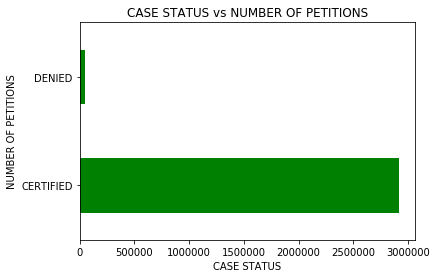

CERTIFIED    2912170
DENIED         48852
Name: CASE_STATUS, dtype: int64


In [21]:
plot_status_numberinit = df_cleaned['CASE_STATUS'].value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("CASE STATUS")
plot_status_numberinit.set_ylabel("NUMBER OF PETITIONS")
plt.show()
print(df_cleaned['CASE_STATUS'].value_counts())

In [22]:
df_cleaned['EMPLOYER_NAME'] = df_cleaned['EMPLOYER_NAME'].str.upper()
df_cleaned['SOC_NAME'] = df_cleaned['SOC_NAME'].str.upper()
df_cleaned['JOB_TITLE'] = df_cleaned['JOB_TITLE'].str.upper()#datatype conversion for the year column

In [23]:
df_cleaned.head()

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_NAME,SOC_CODE,JOB_TITLE,PREVAILING_WAGE,YEAR
0,I-200-09106-546545,CERTIFIED,TEXAS STATE UNIVERSITY-SAN MARCOS,SAN MARCOS,TX,"BIOLOGICAL SCIENTISTS, ALL OTHER",19-1029,POSTDOCTORAL RESEARCH ASSOCIATE,43118.0,2014
1,I-200-09162-143337,CERTIFIED,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,OPTOMETRISTS,29-1041,OPTOMETRIST,64251.0,2014
2,I-200-09182-550211,DENIED,"LHB, INC.",DULUTH,MN,ACTORS,27-2011,FOOD SAFETY SCIENTIST,50000.0,2014
3,I-200-09193-873099,CERTIFIED,"WAM USA, INC.",LAWRENCEVILLE,GA,ACCOUNTANTS AND AUDITORS,13-2011,INTERNATIONAL ACCOUNTANT,47424.0,2014
4,I-200-09197-120609,CERTIFIED,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,COMPUTER PROGRAMMERS,15-1131,PROGRAMMER ANALYST,61589.0,2014


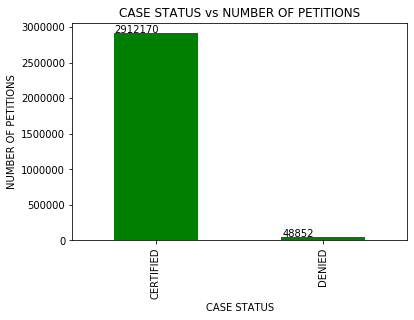

In [24]:
plot_status_number = df_cleaned['CASE_STATUS'].value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', kind = 'bar', color = 'green')
plot_status_number.set_xlabel("CASE STATUS")
plot_status_number.set_ylabel("NUMBER OF PETITIONS")
for p in plot_status_number.patches:
    plot_status_number.annotate(str(p.get_height()), (p.get_x() * 1.0050, p.get_height() * 1.005))
plot_status_number

INFOSYS LIMITED                                    114473
TATA CONSULTANCY SERVICES LIMITED                   71593
DELOITTE CONSULTING LLP                             45216
WIPRO LIMITED                                       42176
ACCENTURE LLP                                       37380
IBM INDIA PRIVATE LIMITED                           32470
CAPGEMINI AMERICA INC                               31988
ERNST & YOUNG U.S. LLP                              25364
TECH MAHINDRA (AMERICAS),INC.                       24056
MICROSOFT CORPORATION                               23726
HCL AMERICA, INC.                                   22549
GOOGLE INC.                                         16383
COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION     14976
LARSEN & TOUBRO INFOTECH LIMITED                    13147
IBM CORPORATION                                     12517
Name: EMPLOYER_NAME, dtype: int64


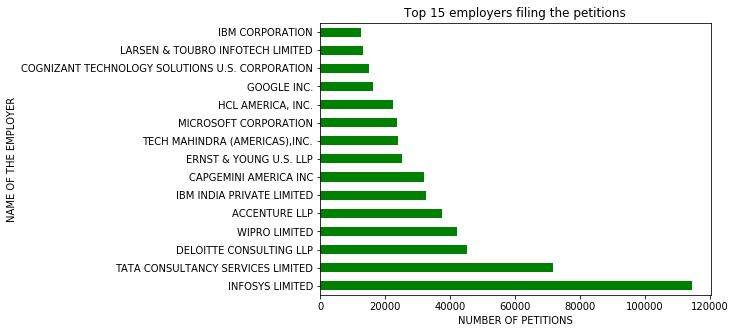

In [25]:
plot_status_topemp= df_cleaned['EMPLOYER_NAME'].value_counts().head(15).plot.barh(title = "Top 15 employers filing the petitions", color = 'green', figsize = (7, 5))
plot_status_topemp.set_ylabel("NAME OF THE EMPLOYER")
plot_status_topemp.set_xlabel("NUMBER OF PETITIONS")
plot_status_topemp
print(df_cleaned['EMPLOYER_NAME'].value_counts().head(15))

SOFTWARE DEVELOPERS, APPLICATIONS                     599185
COMPUTER SYSTEMS ANALYSTS                             448727
COMPUTER PROGRAMMERS                                  325731
COMPUTER OCCUPATIONS, ALL OTHER                       255221
SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE                  97211
MANAGEMENT ANALYSTS                                    63892
ACCOUNTANTS AND AUDITORS                               53057
NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS            48961
COMPUTER SYSTEMS ANALYST                               48325
FINANCIAL ANALYSTS                                     46753
MECHANICAL ENGINEERS                                   44451
OPERATIONS RESEARCH ANALYSTS                           42412
DATABASE ADMINISTRATORS                                40989
MARKET RESEARCH ANALYSTS AND MARKETING SPECIALISTS     36161
ELECTRONICS ENGINEERS, EXCEPT COMPUTER                 31877
Name: SOC_NAME, dtype: int64


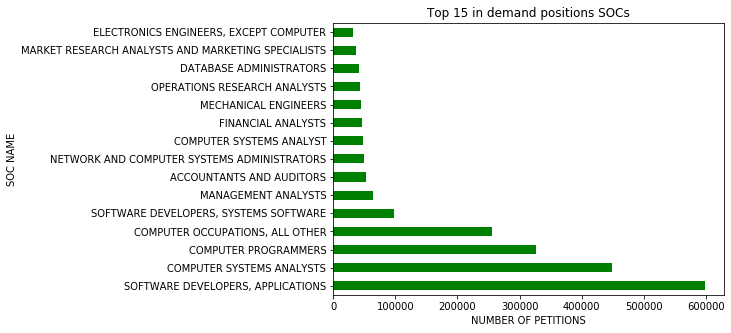

In [26]:
plot_status_topsoc= df_cleaned['SOC_NAME'].value_counts().head(15).plot.barh(title = "Top 15 in demand positions SOCs", color = 'green', figsize = (7, 5))
plot_status_topsoc.set_ylabel("SOC NAME")
plot_status_topsoc.set_xlabel("NUMBER OF PETITIONS")
plot_status_topsoc
print(df_cleaned['SOC_NAME'].value_counts().head(15))

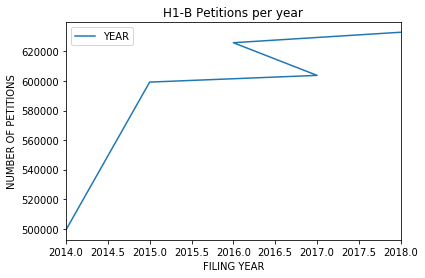

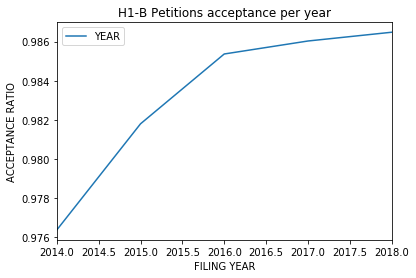

In [27]:
dfplot_status_fyear = pd.DataFrame(df_cleaned['YEAR'].value_counts())
dfplot_status_fyear = dfplot_status_fyear.sort_values(['YEAR'])
plot_status_fyear = dfplot_status_fyear.plot(title = 'H1-B Petitions per year', kind = 'line')
plot_status_fyear.set_xlabel('FILING YEAR')
plot_status_fyear.set_ylabel('NUMBER OF PETITIONS')
plt.show()

dfstatus_acceptance_peryear = pd.DataFrame(df_cleaned[df_cleaned['CASE_STATUS'] == 'CERTIFIED'].YEAR.value_counts() / df_cleaned.YEAR.value_counts())
dfstatus_acceptance_peryear = dfstatus_acceptance_peryear.sort_values(['YEAR'])
status_acceptance_peryear = dfstatus_acceptance_peryear.plot(title = 'H1-B Petitions acceptance per year', kind = 'line')
status_acceptance_peryear.set_xlabel('FILING YEAR')
status_acceptance_peryear.set_ylabel('ACCEPTANCE RATIO')
plt.show()

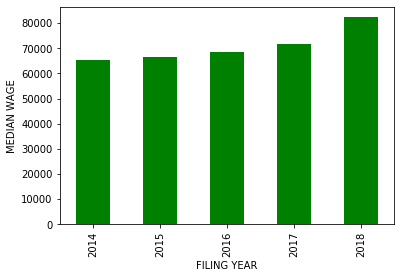

,PREVAILING_WAGE
,median
YEAR,
2014,65562.0
2015,66602.0
2016,68494.0
2017,71843.0
2018,82326.0


In [28]:
dfsalaries_trends_year = df_cleaned.loc[:,['PREVAILING_WAGE', 'YEAR']].groupby(['YEAR']).agg(['median'])

plot_salaries_trends_year = dfsalaries_trends_year.plot(kind = 'bar', color = 'g', legend = None)
plot_salaries_trends_year.set_xlabel('FILING YEAR')
plot_salaries_trends_year.set_ylabel('MEDIAN WAGE')
plt.show()
dfsalaries_trends_year

In [29]:
df_cleaned.isnull().sum(axis = 0)

CASE_NUMBER         0
CASE_STATUS         0
EMPLOYER_NAME       0
EMPLOYER_CITY       0
EMPLOYER_STATE      0
SOC_NAME            0
SOC_CODE            0
JOB_TITLE          11
PREVAILING_WAGE     0
YEAR                0
dtype: int64

In [30]:
table_3 = df_cleaned.dropna(axis=0, how='any', subset = ['EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE', 'PREVAILING_WAGE'])

In [31]:
print(df_cleaned.shape)
print(table_3.shape)

(2961022, 10)
(2961011, 10)


In [32]:
table_3.CASE_STATUS.value_counts()

CERTIFIED    2912163
DENIED         48848
Name: CASE_STATUS, dtype: int64

In [33]:
table_temp_2_Dx = table_3[table_3['CASE_STATUS'] == 'DENIED']

In [35]:
table_temp_2_Cx = table_3[table_3['CASE_STATUS'] == 'CERTIFIED']

In [36]:
Input_Certified, Input_Certified_extra, y_certified, y_certified_extra = train_test_split(table_3[table_3.CASE_STATUS == 'CERTIFIED'], table_temp_2_Cx.CASE_STATUS, train_size= 0.06, random_state=1)

#Input_Certified is the needed x axis data
#Input_certified_extra is the eliminitated attributes data
#Same applied for the Y axis but as the values are "Certified" throughout, it doesn't matter

In [37]:
training_dataframe = Input_Certified.append(table_temp_2_Dx)

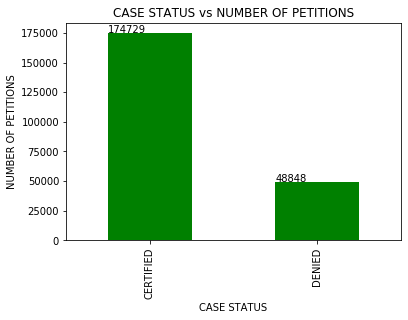

In [38]:
## plot the distribution of the certified and denied samples after downsampling
plot_after_ds = training_dataframe['CASE_STATUS'].value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', kind = 'bar', color = 'green')
plot_after_ds.set_xlabel("CASE STATUS")
plot_after_ds.set_ylabel("NUMBER OF PETITIONS")
for p in plot_after_ds.patches:
    plot_after_ds.annotate(str(p.get_height()), (p.get_x() * 1.0050, p.get_height() * 1.005))
plt.show()

Features Creation and Categorisation
For the given categorical data, they need to convert it to numerical values

There are three ways to convert the categorical data to numerical ones.

Encoding to ordinal values
Feature Hashing
One-Hot Encoding
Prior selecting any of the above methods, it is necessary to get the details of the unique values for each of the columns/Features. Below is the plot for the same.

In [39]:
print("Case Status ",df_cleaned.CASE_STATUS.nunique())
print("Unique Employers Name ",df_cleaned.EMPLOYER_NAME.nunique())
print("Unique Employers City",df_cleaned.EMPLOYER_CITY.nunique())
print("Unique Employers State",df_cleaned.EMPLOYER_STATE.nunique())
print("Unique SOCs CODE ", df_cleaned.SOC_CODE.nunique())
print("Unique SOCs NAME ", df_cleaned.SOC_NAME.nunique())
print("Unique Job Titles ",df_cleaned.JOB_TITLE.nunique())
print("Prevailing Wages ",df_cleaned.PREVAILING_WAGE.nunique())
print("Unique Filing Year ",df_cleaned.YEAR.nunique())

Case Status  2
Unique Employers Name  198539
Unique Employers City 8666
Unique Employers State 58
Unique SOCs CODE  1346
Unique SOCs NAME  1670
Unique Job Titles  295980
Prevailing Wages  57646
Unique Filing Year  5


In [40]:
def wage_categorization(wage):
    if wage <=50000:
        return "VERY LOW"
    elif wage >50000 and wage <= 70000:
        return "LOW"
    elif wage >70000 and wage <= 90000:
        return "MEDIUM"
    elif wage >90000 and wage<=150000:
        return "HIGH"
    elif wage >=150000:
        return "VERY HIGH"

In [41]:
def categorisation_visagrant(ratio_of_acceptance):
    if ratio_of_acceptance == -1:
        return "AR"
    elif ratio_of_acceptance >=0.0 and ratio_of_acceptance<0.20:
        return "VLA"
    elif ratio_of_acceptance>=0.20 and ratio_of_acceptance<0.40:
        return "LA"
    elif ratio_of_acceptance>=0.40 and ratio_of_acceptance<0.60:
        return "MA"
    elif ratio_of_acceptance>=0.60 and ratio_of_acceptance<0.80:
        return "HA"
    elif ratio_of_acceptance>=0.80:
        return "VHA"

 Feature Creation for One-Hot Encoding

In [42]:
df_cleaned['WAGE_CATEGORY'] = df_cleaned['PREVAILING_WAGE'].apply(wage_categorization)

In [43]:
df_cleaned_1 = df_cleaned.loc[:,['EMPLOYER_NAME', 'CASE_STATUS']]
df_cleaned_1s = df_cleaned.loc[:,['SOC_NAME', 'CASE_STATUS']]
df_cleaned_1j = df_cleaned.loc[:,['JOB_TITLE', 'CASE_STATUS']]

In [44]:
df_cleaned_2_C = df_cleaned_1[df_cleaned_1.CASE_STATUS == 'CERTIFIED'].EMPLOYER_NAME
df_cleaned_2_Cs = df_cleaned_1s[df_cleaned_1s.CASE_STATUS == 'CERTIFIED'].SOC_NAME
df_cleaned_2_Cj = df_cleaned_1j[df_cleaned_1j.CASE_STATUS == 'CERTIFIED'].JOB_TITLE
positive_counts = df_cleaned_2_C.value_counts()
positive_counts_s = df_cleaned_2_Cs.value_counts()
positive_counts_j = df_cleaned_2_Cj.value_counts()

In [45]:
total_counts = df_cleaned_1.EMPLOYER_NAME.value_counts()
total_counts_s = df_cleaned_1s.SOC_NAME.value_counts()
total_counts_j = df_cleaned_1j.JOB_TITLE.value_counts()

In [46]:
final_ratio_series = positive_counts / total_counts

final_ratio_series.fillna(-1, inplace=True)
final_classification_employer = final_ratio_series.apply(categorisation_visagrant)
df_cleaned['EMPLOYER_ACCEPTANCE'] = df_cleaned.EMPLOYER_NAME.map(final_classification_employer)

In [47]:
final_ratio_series_s = positive_counts_s / total_counts_s
final_ratio_series_s.fillna(-1, inplace=True)
final_classification_soc = final_ratio_series_s.apply(categorisation_visagrant)
df_cleaned['SOC_ACCEPTANCE'] = df_cleaned.SOC_NAME.map(final_classification_soc)

In [48]:
final_ratio_series_j = positive_counts_j / total_counts_j
final_ratio_series_j.fillna(-1, inplace=True)
final_classification_job = final_ratio_series_j.apply(categorisation_visagrant)
df_cleaned['JOB_ACCEPTANCE'] = df_cleaned.JOB_TITLE.map(final_classification_job)

In [49]:
print("Case Status ",df_cleaned.CASE_STATUS.nunique())
print("Unique Employers ",df_cleaned.EMPLOYER_ACCEPTANCE.nunique())
print("Wages Category", df_cleaned.WAGE_CATEGORY.nunique())
print("Unique SOCs ", df_cleaned.SOC_ACCEPTANCE.nunique())
print("Unique Job Titles ",df_cleaned.JOB_ACCEPTANCE.nunique())
print("Unique Filing Year ",df_cleaned.YEAR.nunique())


Case Status  2
Unique Employers  6
Wages Category 5
Unique SOCs  6
Unique Job Titles  6
Unique Filing Year  5


In [50]:
dict_cs = {"CERTIFIED" : 1, "DENIED": 0}
try:
    
    df_cleaned['CASE_STATUS'] = df_cleaned['CASE_STATUS'].apply(lambda x: dict_cs[x])
except:
    pass

In [51]:
df_cleaned['YEAR'] = df_cleaned['YEAR'].astype('int')
df_cleaned.sort_index(inplace = True)
df_cleaned = df_cleaned.loc[:, ['CASE_STATUS', 'YEAR','WAGE_CATEGORY',  'EMPLOYER_ACCEPTANCE', 'JOB_ACCEPTANCE', 'SOC_ACCEPTANCE']]
df_cleaned.head()

,CASE_STATUS,YEAR,WAGE_CATEGORY,EMPLOYER_ACCEPTANCE,JOB_ACCEPTANCE,SOC_ACCEPTANCE
0,1,2014,VERY LOW,VHA,VHA,VHA
0,1,2017,LOW,VHA,VHA,VHA
0,1,2018,HIGH,VHA,VHA,VHA
0,1,2016,VERY LOW,VHA,VHA,VHA
1,1,2016,VERY HIGH,VHA,VHA,VHA


Apply one hot coding

In [52]:
final_df_train = pd.get_dummies(df_cleaned, columns=['YEAR', 'WAGE_CATEGORY', 'EMPLOYER_ACCEPTANCE', 'JOB_ACCEPTANCE', 'SOC_ACCEPTANCE' ], drop_first=True)
final_df_train.head()

,CASE_STATUS,YEAR_2015,YEAR_2016,YEAR_2017,YEAR_2018,WAGE_CATEGORY_LOW,WAGE_CATEGORY_MEDIUM,WAGE_CATEGORY_VERY HIGH,WAGE_CATEGORY_VERY LOW,EMPLOYER_ACCEPTANCE_HA,...,JOB_ACCEPTANCE_HA,JOB_ACCEPTANCE_LA,JOB_ACCEPTANCE_MA,JOB_ACCEPTANCE_VHA,JOB_ACCEPTANCE_VLA,SOC_ACCEPTANCE_HA,SOC_ACCEPTANCE_LA,SOC_ACCEPTANCE_MA,SOC_ACCEPTANCE_VHA,SOC_ACCEPTANCE_VLA
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [53]:
model = LogisticRegression()
rfe = RFE(model, 30)
fit = rfe.fit(final_df_train.iloc[:,1:], final_df_train.iloc[:,0])
support_rfe = rfe.support_
length_cols = list(final_df_train.iloc[:,1:].columns.values)
list_selected = []
for index in range(len(length_cols)):
    if support_rfe[index] == True:
        list_selected.append(length_cols[index])
    else:
        pass
print(list_selected)
print(rfe.ranking_)     # ref.ranking_ returns an array with positive integer values 
                         # to indicate the attribute ranking with a lower score indicating a higher ranking 

['YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'WAGE_CATEGORY_LOW', 'WAGE_CATEGORY_MEDIUM', 'WAGE_CATEGORY_VERY HIGH', 'WAGE_CATEGORY_VERY LOW', 'EMPLOYER_ACCEPTANCE_HA', 'EMPLOYER_ACCEPTANCE_LA', 'EMPLOYER_ACCEPTANCE_MA', 'EMPLOYER_ACCEPTANCE_VHA', 'EMPLOYER_ACCEPTANCE_VLA', 'JOB_ACCEPTANCE_HA', 'JOB_ACCEPTANCE_LA', 'JOB_ACCEPTANCE_MA', 'JOB_ACCEPTANCE_VHA', 'JOB_ACCEPTANCE_VLA', 'SOC_ACCEPTANCE_HA', 'SOC_ACCEPTANCE_LA', 'SOC_ACCEPTANCE_MA', 'SOC_ACCEPTANCE_VHA', 'SOC_ACCEPTANCE_VLA']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [54]:
unique_listcols = [col.split('_')[0] for col in list_selected]
set(unique_listcols)

{'EMPLOYER', 'JOB', 'SOC', 'WAGE', 'YEAR'}

Splitting into training and test data

In [55]:
X_train, X_test, y_train, y_test = train_test_split(final_df_train.iloc[:,1:], final_df_train.iloc[:, 0], test_size = 0.20, random_state=1)
#y_train[y_train==1].shape
y_test[y_test==1].shape

(582365,)

In [56]:
X_train.head()

,YEAR_2015,YEAR_2016,YEAR_2017,YEAR_2018,WAGE_CATEGORY_LOW,WAGE_CATEGORY_MEDIUM,WAGE_CATEGORY_VERY HIGH,WAGE_CATEGORY_VERY LOW,EMPLOYER_ACCEPTANCE_HA,EMPLOYER_ACCEPTANCE_LA,...,JOB_ACCEPTANCE_HA,JOB_ACCEPTANCE_LA,JOB_ACCEPTANCE_MA,JOB_ACCEPTANCE_VHA,JOB_ACCEPTANCE_VLA,SOC_ACCEPTANCE_HA,SOC_ACCEPTANCE_LA,SOC_ACCEPTANCE_MA,SOC_ACCEPTANCE_VHA,SOC_ACCEPTANCE_VLA
343814,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
580599,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
51139,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
32913,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
161225,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Training classifiers


Decision Tree Model

In [57]:
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

In [58]:
y_pred = dtree.predict(X_test)

y_prob = dtree.predict_proba(X_test)

print("test", y_test[:10])
print("pred", y_pred[:10])
print()

print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.classification_report(y_test, y_pred))
#print(metrics.precision_score(y_test,y_pred))   # Parameter "average" is requred if not a binary model
#print(metrics.recall_score(y_test,y_pred))      # Parameter "average" is requred if not a binary model
#print(metrics.f1_score(y_test,y_pred))  

test 212700    1
542819    1
497432    1
40799     1
437295    1
472779    1
622807    1
460563    1
183391    1
19160     1
Name: CASE_STATUS, dtype: int64
pred [1 1 1 1 1 1 1 1 1 1]

[[  2249   7591]
 [  1004 581361]]
              precision    recall  f1-score   support

           0       0.69      0.23      0.34      9840
           1       0.99      1.00      0.99    582365

    accuracy                           0.99    592205
   macro avg       0.84      0.61      0.67    592205
weighted avg       0.98      0.99      0.98    592205



Logistic Regression Mode

In [59]:
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_pred_lr = lr_clf.predict(X_test)

probs = lr_clf.predict_proba(X_test)

print("test", y_test[:10])
print("pred", y_pred_lr[:10])

print(metrics.confusion_matrix(y_test,y_pred_lr))
print(metrics.classification_report(y_test, y_pred_lr))
#print(metrics.precision_score(y_test,y_pred))   # Parameter "average" is requred if not a binary model
#print(metrics.recall_score(y_test,y_pred))      # Parameter "average" is requred if not a binary model
#print(metrics.f1_score(y_test,y_pred))

test 212700    1
542819    1
497432    1
40799     1
437295    1
472779    1
622807    1
460563    1
183391    1
19160     1
Name: CASE_STATUS, dtype: int64
pred [1 1 1 1 1 1 1 1 1 1]
[[  2381   7459]
 [  1178 581187]]
              precision    recall  f1-score   support

           0       0.67      0.24      0.36      9840
           1       0.99      1.00      0.99    582365

    accuracy                           0.99    592205
   macro avg       0.83      0.62      0.67    592205
weighted avg       0.98      0.99      0.98    592205



Random Forest Classifier

In [61]:
rf = RandomForestClassifier(n_estimators = 75, random_state = 50)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [62]:
y_pred_rf =  rf.predict(X_test)
probs = rf.predict_proba(X_test)

print("test", y_test[:10])
print("pred", y_pred[:10])
print(metrics.confusion_matrix(y_test,y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))
#print(metrics.precision_score(y_test,y_pred_rf))   # Parameter "average" is requred if not a binary model
#print(metrics.recall_score(y_test,y_pred))
#print(metrics.f1_score(y_test, y_pred))# Parameter "average" is requred if not a binary model

test 212700    1
542819    1
497432    1
40799     1
437295    1
472779    1
622807    1
460563    1
183391    1
19160     1
Name: CASE_STATUS, dtype: int64
pred [1 1 1 1 1 1 1 1 1 1]
[[  2187   7653]
 [   936 581429]]
              precision    recall  f1-score   support

           0       0.70      0.22      0.34      9840
           1       0.99      1.00      0.99    582365

    accuracy                           0.99    592205
   macro avg       0.84      0.61      0.67    592205
weighted avg       0.98      0.99      0.98    592205



Gaussian Naive Bayes Classifier

In [63]:
gaus_clf = GaussianNB()
gaus_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [64]:
y_pred_glb = gaus_clf.predict(X_test)
confusion = metrics.confusion_matrix(y_test, y_pred_glb)
print(confusion)
print(metrics.classification_report(y_test, y_pred_glb))

[[  5319   4521]
 [  7299 575066]]
              precision    recall  f1-score   support

           0       0.42      0.54      0.47      9840
           1       0.99      0.99      0.99    582365

    accuracy                           0.98    592205
   macro avg       0.71      0.76      0.73    592205
weighted avg       0.98      0.98      0.98    592205

